In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import os

def delete_folder(folder_path):
    if os.path.exists(folder_path):
        for root, dirs, files in os.walk(folder_path, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
        os.rmdir(folder_path)
    else:
        print(f"The folder {folder_path} does not exist")

delete_folder('./runs')

In [3]:
'''
Pre-defined constants
'''
n = 55000  # The size of training set
scale = 1e-2 # the scale factor for loss function
damp = 1 # the damp factor to add L2 regularization in loss function
criterion = torch.nn.CrossEntropyLoss() # loss function without scaling and regularization
device = 'cpu'
iteration = 10

In the section below, we would load training dataset and testing dataset from MNIST. We assign the training set size $n=55000$, which is accorded to the paper Understanding Black-box Predictions via Influence Functions

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

train_dataset_all = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True,
                              transform=transform, )

train_indices = torch.randperm(len(train_dataset_all))[:n]
train_dataset = Subset(train_dataset_all, train_indices)

In [5]:
all_data_list = []
all_labels_list = []
for i in range(len(train_dataset)):
    data, label = train_dataset[i]
    all_data_list.append(data)         # img shape: [1, 28, 28]
    all_labels_list.append(label)

train_data = torch.stack(all_data_list, dim=0).to(device)  # shape [n, 1, 28, 28]
train_labels = torch.tensor(all_labels_list).to(device)        # shape [n]

## MNIST Logistic Regression Model Definition

Below we defined the logistic regression model with training and testing method using L-BFGS optimizer

In [6]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim, params=None):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        if params:
            self.linear.weight = nn.Parameter(params['weight'])
            self.linear.bias = nn.Parameter(params['bias'])
        
    def forward(self, x):
        x = x.view(-1, self.linear.in_features)
        # outputs = torch.nn.functional.softmax(self.linear(x))
        outputs = self.linear(x)
        return outputs

In [7]:
def train_lbfgs(model, criterion, train_data, train_labels, writer=None, t=20, leave_out_index=None):
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=50, line_search_fn='strong_wolfe')
    # If there is a leave-out indices list, exclude these indies from the training set
    if leave_out_index is not None:
        train_data = torch.cat((train_data[:leave_out_index], train_data[leave_out_index + 1:]), dim=0) 
        train_labels = torch.cat((train_labels[:leave_out_index], train_labels[leave_out_index + 1:]), dim=0)        
    
    for epoch in range(t):  
        def closure():
            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_labels)
            loss.backward()
            return loss
        
        loss_val = optimizer.step(closure)
        if writer:
            writer.add_scalar('training loss', loss_val, epoch)
        # print(f"epoch {epoch} finished, loss={loss_val}")        
    return

In [8]:
'''
Batch validation for the model
'''
def test(model, criterion, test_dataset):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    val_loss = 0
    val_correct = 0
    incorrect_data_list, incorrect_label_list = [], []
    with torch.no_grad():  # Disable gradient calculation during validation
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            # Forward pass
            outputs = model(data.view(-1, 28*28))

            # Calculate loss
            loss = criterion(outputs, labels)

            # Update validation metrics (e.g., accuracy)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            incorrect_data_list.append(data[predicted != labels])
            incorrect_label_list.append(labels[predicted != labels])
            
    incorrect_data = torch.cat(incorrect_data_list, dim=0)
    incorrect_label = torch.cat(incorrect_label_list, dim=0)
    val_loss /= len(test_dataset)
    val_accuracy = 100 * val_correct / len(test_dataset)
    return val_loss, val_accuracy, incorrect_data, incorrect_label

## Train the baseline model in L-BFGS Optimizer and calculate $L(z, \hat{\theta})$

In [9]:
'''
Create a summary writer for plotting training loss
'''
model_train_writer = SummaryWriter('runs/logistic_regression_10_mnist_train')

In [10]:
base_model = LogisticRegression(28*28, 10).to(device)
# Store the initial parameter values for later leave-one-out retrain
initial_params = {"weight": base_model.linear.weight.data.clone(), "bias": base_model.linear.bias.data.clone()}

def criterion_l2(output, target, model):
    loss = criterion(output, target)
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param, 2)**2
    loss += damp * l2_reg
    return loss * scale

base_model_criterion = lambda x, y: criterion_l2(x, y, base_model)
train_lbfgs(base_model, base_model_criterion, train_data, train_labels, writer=model_train_writer, t=iteration)

In [11]:
val_loss, val_accuracy, incorrect_data, incorrect_label = test(base_model, base_model_criterion, test_dataset)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Validation Loss: 0.0003, Validation Accuracy: 77.37%


## Calculate loss difference of leave-one-out retraining

According to the paper, we arbitrarily picked a wrongly-classified test point $z_{test}=(x_{test}, y_{test})$ as below

In [12]:
test_data_index = torch.randint(0, len(incorrect_data), (1,)).item()
x_test, y_test = incorrect_data[test_data_index], incorrect_label[test_data_index].view(1)

In [13]:
def calc_leave_out_loss_diff(model, initial_params, criterion_l2, test_data, test_label, leave_out_index=None, t=1):
    # Clone initial parameters
    params = {"weight": initial_params["weight"].clone(), "bias": initial_params["bias"].clone()}
    
    # Calculate L(z_{test}, \theta) which model is trained with all training points
    loss_z_test_with_z = criterion_l2(model(test_data), test_label, model)
    
    # Train leave-one-out model
    retrained_model = LogisticRegression(28*28, 10, params=params).to(device)
    retrained_model_criterion = lambda x, y: criterion_l2(x, y, retrained_model)
    train_lbfgs(retrained_model, retrained_model_criterion, train_data, train_labels, t=t, leave_out_index=leave_out_index)
    
    # Calculate L(z_{test}, \theta_{-z}) which model is trained without data point z
    loss_z_test_without_z = retrained_model_criterion(retrained_model(test_data), test_label)
    
    leave_out_loss_diff = loss_z_test_without_z - loss_z_test_with_z
    # print(f"loss_z_test_with_z: {loss_z_test_with_z}, loss_z_test_without_z: {loss_z_test_without_z}, leave_out_loss_diff: {leave_out_loss_diff}")
    return leave_out_loss_diff

In [14]:
'''
Validate the functionality of calc_leave_out_loss_diff
'''
leave_out_loss_diff = calc_leave_out_loss_diff(base_model, initial_params, criterion_l2, x_test, y_test, t=iteration, leave_out_index=None)
assert leave_out_loss_diff == 0

## Implement Influence Function

### 0. Preparation

Since in influence function stochastic estimation, we need to uniformly sample $t$ points from training set, an uniform sampling method would be neccessary to be defined as below:

In [15]:
def uniform_sample_dataset(dataset, t, batch_size=1):
    sampler = torch.utils.data.sampler.RandomSampler(dataset, num_samples=t)
    sampled_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return sampled_dataloader

Define a method to calculate first order gradient of multivariable scalar function (in our case, loss function) for all the parameters:
$$\nabla_{\theta} L(z, \theta)$$

In [16]:
def calc_first_order_gradient(loss, model):
    model.zero_grad()
    # Compute the first-order gradient
    loss.backward()
    param_grads = [ p.grad.flatten() for p in model.parameters() if p.requires_grad ]
    param_grads = torch.cat(param_grads)
    return param_grads

Define a method to calculate second order gradient of multivariable scalar function (i.e. Hessian matrix) for all the parameters:
$$\nabla^{2}_{\theta} L(z, \theta)$$

Noted this method would not be used for any reason other than validation purpose, since it is not efficient and for our implementation, HVP (Hessian Vector Product) would be a better choice.

In [17]:
def calc_second_order_gradient(loss, model):
    model.zero_grad()
    # Compute the first-order gradient
    loss.backward(create_graph=True)
    first_grads = [ p.grad.flatten() for p in model.parameters() if p.requires_grad ]
    # Compute the second-order gradient
    second_grads = []
    for first_grad in first_grads:
        row = []
        for p in model.parameters():
            # Compute every possible combination of differentiation variables for the parameters
            sub_matrix = []
            for i in range(first_grad.shape[0]):
                sub_matrix.append(torch.autograd.grad(first_grad[i], p, create_graph=True)[0].flatten())
            sub_matrix = torch.stack(sub_matrix)
            row.append(sub_matrix)
        row = torch.cat(row, dim=1)
        second_grads.append(row)
    second_grads = torch.cat(second_grads, dim=0)
    return second_grads

### 1. HVP (Hessian Vector Product) Calculation

This method could accer

In [18]:
def hvp(loss, params, vector):
    # Compute the first-order gradient
    first_grads = torch.autograd.grad(loss, params, create_graph=True)

    first_grads = [g.flatten() for g in first_grads]
    first_grads = torch.cat(first_grads, dim=0)
    
    # Calculate the product between the first gradients and the vector
    first_grad_vector_product = torch.sum(first_grads * vector)

    # Compute the second-order gradient
    second_grads = torch.autograd.grad(first_grad_vector_product, params, create_graph=True)
    second_grads = [g.flatten() for g in second_grads]
    second_grads = torch.cat(second_grads, dim=0)

    return second_grads

**Validation for HVP**

In [19]:
'''
Validate the correctness of HVP's implementation
'''

test_model = LogisticRegression(2, 2)
test_criterion = torch.nn.MSELoss()

data_tensor = torch.tensor([[1.0, -2.0]], requires_grad=True)
label_tensor = torch.tensor([1.0, 0.0])

params = [p for p in test_model.parameters()]
vector = calc_first_order_gradient(test_criterion(test_model(data_tensor), label_tensor), test_model)
expected = torch.matmul(calc_second_order_gradient(test_criterion(test_model(data_tensor), label_tensor), test_model), vector.T)
vector._grad_fn = None
test_model.zero_grad()
actual = hvp(torch.nn.MSELoss()(test_model(data_tensor), label_tensor), params, vector)
print(f"Expected HVP: {expected} \nActual HVP: {actual} \nDiff Sum: {(expected-actual).sum()}")
assert torch.equal(expected, actual)

Expected HVP: tensor([-16.0884,  32.1769,   4.0581,  -8.1161, -16.0884,   4.0581],
       grad_fn=<MvBackward0>) 
Actual HVP: tensor([-16.0884,  32.1769,   4.0581,  -8.1161, -16.0884,   4.0581],
       grad_fn=<CatBackward0>) 
Diff Sum: 0.0


/Users/zpvoh/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/zpvoh/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torch/autograd/__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403213615/work/torch/csrc/autograd/engine.cpp:1182.)
  Variable._execution_engi

### 2. IHVP (Inverse Hessian Vector Product) Calculation



In [20]:
def ihvp(train_dataset, test_data, test_label, model, criterion, t, r, unique_datapoint=None, ihvp_summary_writer=None):
    ihvp_eval_avg = 0
    vector = calc_first_order_gradient(criterion(model(test_data), test_label), model)
    for i in range(r):
        # Arg unique_datapoint is used for debugging. It would generate an assigned single-data dataset
        if unique_datapoint is None:
            sampled_train_dataset = [(data, label) for data, label in uniform_sample_dataset(train_dataset, t)]
        else:
            sampled_train_dataset = []
            for _ in range(t):
                sampled_train_dataset.append(unique_datapoint)
        # Step 1. Initialize the evaluation of the Hessian-vector product
        ihvp_eval = vector
        data_number = 0
        for data, label in sampled_train_dataset:
            # data, label = data.to(device), label.to(device)
            # Step 2. Compute the second order gradient of the loss w.r.t. the model parameters
            model.zero_grad()
            data_tensor = data.view(-1, 28*28)
            params = [p for p in model.parameters()]
            ihvp_eval._grad_fn = None
            # Step 3. Compute the inner product between the Hessian matrix and the test gradient vector using HVP
            hvp_eval = hvp(criterion(model(data_tensor), label), params, ihvp_eval)
            ihvp_eval = ihvp_eval + vector - hvp_eval
            if ihvp_summary_writer:
                ihvp_summary_writer.add_scalar(f'ihvp_eval_sum_{i}', ihvp_eval.sum(), data_number)
            data_number += 1
        print(f"ihvp iteration {i} done and ihvp sum is {ihvp_eval.sum()}")
        ihvp_eval_avg = i / (i + 1) * ihvp_eval_avg + 1 / (i + 1) * ihvp_eval   
    return ihvp_eval_avg

**Validation for IHVP**: 
Check if IHVP successfully convergent

In [21]:
uni_data_loader  = uniform_sample_dataset(train_dataset, 1)
uni_data_tuple = ()
for data, label in uni_data_loader:
    uni_data_tuple = (data.to(device), label.to(device))

In [22]:
ihvp_summary_writer = SummaryWriter('runs/ihvp_sum_summary') 
print(f"Test data value sum: {x_test.sum()}, Test data label: {y_test}")
ihvp_eval = ihvp(train_dataset, x_test, y_test, base_model, base_model_criterion, 5000, 10, ihvp_summary_writer=ihvp_summary_writer)
print(ihvp_eval)

Test data value sum: 84.62353515625, Test data label: tensor([3])
ihvp iteration 0 done and ihvp sum is -0.00037457793951034546
ihvp iteration 1 done and ihvp sum is -0.00037629902362823486
ihvp iteration 2 done and ihvp sum is -0.00037566572427749634
ihvp iteration 3 done and ihvp sum is -0.0003763362765312195
ihvp iteration 4 done and ihvp sum is -0.0003770068287849426
ihvp iteration 5 done and ihvp sum is -0.000376187264919281
ihvp iteration 6 done and ihvp sum is -0.00037470459938049316
ihvp iteration 7 done and ihvp sum is -0.00037657469511032104
ihvp iteration 8 done and ihvp sum is -0.00037382543087005615
ihvp iteration 9 done and ihvp sum is -0.00037570297718048096
tensor([-5.7487e-06,  5.3363e-06,  3.3305e-07,  ...,  2.3679e-02,
         1.3323e-02,  2.1043e-02], grad_fn=<AddBackward0>)


In [23]:
ihvp_eval.sum()

tensor(-0.0004, grad_fn=<SumBackward0>)

### 3. Influence Function Implementation

In [24]:
def upweighting_loss_influence_function(s_test, train_dataset, upweighted_data, upweighted_label, test_data, test_label, model, criterion):
    # Step 1. Compute the Inverse Hessian-vector product
    # ihvp_eval = ihvp(train_dataset, test_data, test_label, model, criterion, 5000, 5)
    # Step 2. Compute the influence function
    first_grad = calc_first_order_gradient(criterion(model(upweighted_data), upweighted_label), model)
    influence = torch.matmul(-s_test, first_grad)
    return influence

In [25]:
influence = upweighting_loss_influence_function(ihvp_eval, train_dataset, train_data[0], train_labels[0].view(1), x_test, y_test, base_model, base_model_criterion)

In [26]:
-influence / n, calc_leave_out_loss_diff(base_model, initial_params, criterion_l2, x_test, y_test, t=iteration, leave_out_index=0)

(tensor(-1.3143e-07, grad_fn=<DivBackward0>),
 tensor(-8.3447e-07, grad_fn=<SubBackward0>))

In [27]:
from tqdm import tqdm

influence_list = []
for i in tqdm(range(n), desc="Processing"):
    influence = upweighting_loss_influence_function(ihvp_eval, train_dataset, train_data[i], train_labels[i].view(1), x_test, y_test, base_model, base_model_criterion)
    predicted_diff = (influence, -influence / n, i)
    influence_list.append(predicted_diff)
    
top_abs_500_list = sorted(influence_list, key=lambda pair: torch.abs(pair[0]), reverse=True)[:500]

Processing:   0%|          | 0/55000 [00:00<?, ?it/s]

Processing: 100%|██████████| 55000/55000 [00:21<00:00, 2589.49it/s]


In [28]:
top_abs_500_list = sorted(influence_list, key=lambda pair: torch.abs(pair[0]), reverse=True)[:500]

In [29]:
top_abs_500_1000_list = sorted(influence_list, key=lambda pair: torch.abs(pair[0]), reverse=True)[500:1000]

In [30]:
influence_leave_out_diff_list = []
for influence, predict, idx in tqdm(top_abs_500_list, desc="Progressing..."):
    leave_out_loss_diff = calc_leave_out_loss_diff(base_model, initial_params, criterion_l2, x_test, y_test, t=iteration, leave_out_index=idx)
    pair = (predict, leave_out_loss_diff)
    influence_leave_out_diff_list.append(pair)

Progressing...: 100%|██████████| 500/500 [1:28:12<00:00, 10.58s/it]


In [31]:
# influence_leave_out_diff_list_1000 = []
for influence, predict, idx in tqdm(top_abs_500_1000_list, desc="Progressing..."):
    leave_out_loss_diff = calc_leave_out_loss_diff(base_model, initial_params, criterion_l2, x_test, y_test, t=iteration, leave_out_index=idx)
    pair = (predict, leave_out_loss_diff)
    influence_leave_out_diff_list.append(pair)

Progressing...: 100%|██████████| 500/500 [1:28:41<00:00, 10.64s/it]


Matplotlib is building the font cache; this may take a moment.


1000


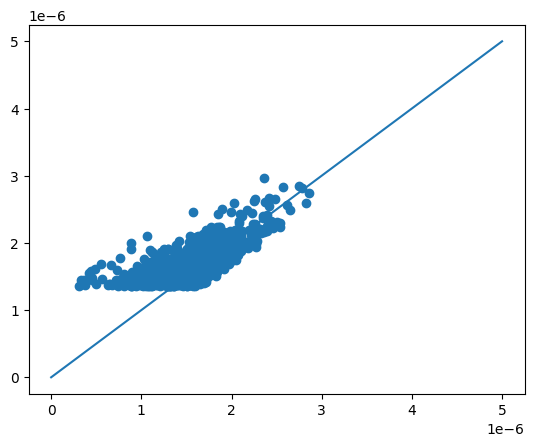

In [33]:
import matplotlib.pyplot as plt
import numpy as np

x_list, y_list = [], []
for y, x in influence_leave_out_diff_list:
    # if torch.abs(-x-y)>4*torch.abs(x):
    #     continue
    x_list.append(x.item())
    y_list.append(y.item())
    
x_dig = [0, 5e-6]
y_dig = [0, 5e-6]
plt.scatter(x_list, y_list)
plt.plot(x_dig, y_dig)

print(len(x_list))

In [31]:
sorted_influence_list = sorted(influence_list, key=lambda pair: torch.abs(pair[1]), reverse=True)[:3000]
positive_count = 0
positive_rank_avg = 0
for i in range(len(sorted_influence_list)):
    ele = sorted_influence_list[i]
    if ele[1] > 0:
        positive_rank_avg = positive_count / (positive_count + 1) * positive_rank_avg + 1 / (positive_count + 1) * i
        positive_count += 1
positive_count, positive_rank_avg

(3000, 1499.5)

In [32]:
stored = [influence_list, influence_leave_out_diff_list]
torch.save(stored, "influence_lists.pt")

In [33]:
# extracted = torch.load("influence_lists.pt")

In [39]:
a = sorted(influence_list, key=lambda pair: pair[0], reverse=True)[:500]

In [ ]:
top_abs_500_list